# Climent Sentiment Analysis

### Introduction
As sustainability becomes a core value for many businesses, understanding public sentiment around climate change is increasingly important. Companies offering environmentally friendly products and services are especially interested in how people perceive climate change—whether they consider it a pressing issue or dismiss it as a hoax. These insights can inform marketing strategies, product development, and overall brand positioning.

In this project, I build a machine learning classification model to automatically determine climate change sentiment based on tweet content. The model predicts whether a person believes in man-made climate change, using labeled tweet data.

#### Data
Data The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo. The dataset aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. In total, 43943 tweets were collected. Each tweet is labelled as one of the following classes:

#### Class Description

* 2 News: the tweet links to factual news about climate change
* 1 Pro: the tweet supports the belief of man-made climate change
* 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change
* -1 Anti: the tweet does not believe in man-made climate change

#### Variable definitions

* sentiment: Sentiment of tweet
* message: Tweet body
* tweetid: Twitter unique id

<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Model Explanations</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

---
    

Here we import the various libraries that we will be using throughout the the various sections of the notebook. 

In [39]:
#libraries for data loading,  manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS

#libraries for engineering our data
import re
from sklearn.utils import resample
from nltk.tokenize import word_tokenize, TreebankWordTokenizer, TweetTokenizer
from nltk import SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

#libraries for feature pre-processing and scaling 
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

#libraries for midelling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

#libraries for assessing model performance
from sklearn import metrics
from sklearn.metrics import classification_report


<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


In [2]:
#load our train data
train_df = pd.read_csv('train.csv')
train_df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [3]:
#load our test data
test_df = pd.read_csv('test_with_no_labels.csv')
test_df.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>



### 3.1 Non-graphical EDA

In [4]:
# look at data...
train_df.shape

(15819, 3)

We have only 3 columns as seen above. Our dataset is also made up of 15819 observations, i.e., tweet samples.

In [5]:
test_df.shape

(10546, 2)

Our test dataset has one less column, which is expected as it does to contain the labels

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


No null entries in our dataset

Let us print a list of all the sentiments categories that are present in our datasaet

In [7]:
train_df.sentiment.unique()

array([ 1,  2,  0, -1], dtype=int64)

We have four sentiment classes as expected. This means we are working with a multi-class classification problem. Their description is as follows:

* 2 News: the tweet links to factual news about climate change
* 1 Pro: the tweet supports the belief of man-made climate change
* 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change
* -1 Anti: the tweet does not believe in man-made climate change

In [63]:
train_df.describe(include=object)

,message
count,15819
unique,14229
top,RT @StephenSchlegel: she's thinking about how ...
freq,307


The train data has 15819 observations but out of those, only 14229 are unique. This shows that there are some duplicate values in our dataset. Considering we are working with tweets, this is likley to be as a result of retweeted tweets. We will keep them as they add to our sample size.

### 3.2 Graphical Analyisis

Let us see how our tweets are distributed among the four categories

In [8]:
train_df['sentiment'].value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

In [4]:
#dataframe to store the sentiments and their counts
train_df_sum=train_df[['sentiment', 'message']].groupby('sentiment').count()
train_df_sum.columns=['Sum']
train_df_sum

,Sum
sentiment,
-1,1296
0,2353
1,8530
2,3640


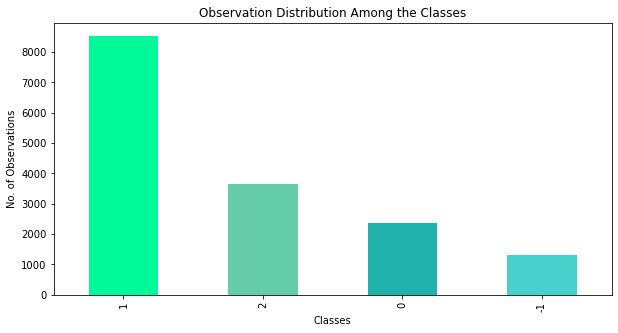

In [71]:
# plot observations against the classes
train_df['sentiment'].value_counts().plot(kind='bar', color=['mediumspringgreen', 'mediumaquamarine', 'lightseagreen', 'mediumturquoise'])
plt.title('Observation Distribution Among the Classes')
plt.xlabel('Classes')
plt.ylabel('No. of Observations')
plt.show()

It seems most people belive in man made climate change while those who do not belive in the same are one the lower side. We can also see that we have an imbalanced dataset. 

#### Most Common Words Per Class

Visualizing the most commonly occuring words per class using a **WordCloud**

In [5]:
from ast import literal_eval
clean_train_df=pd.read_csv('clean_train.csv', converters={'message_lemmatized': literal_eval})

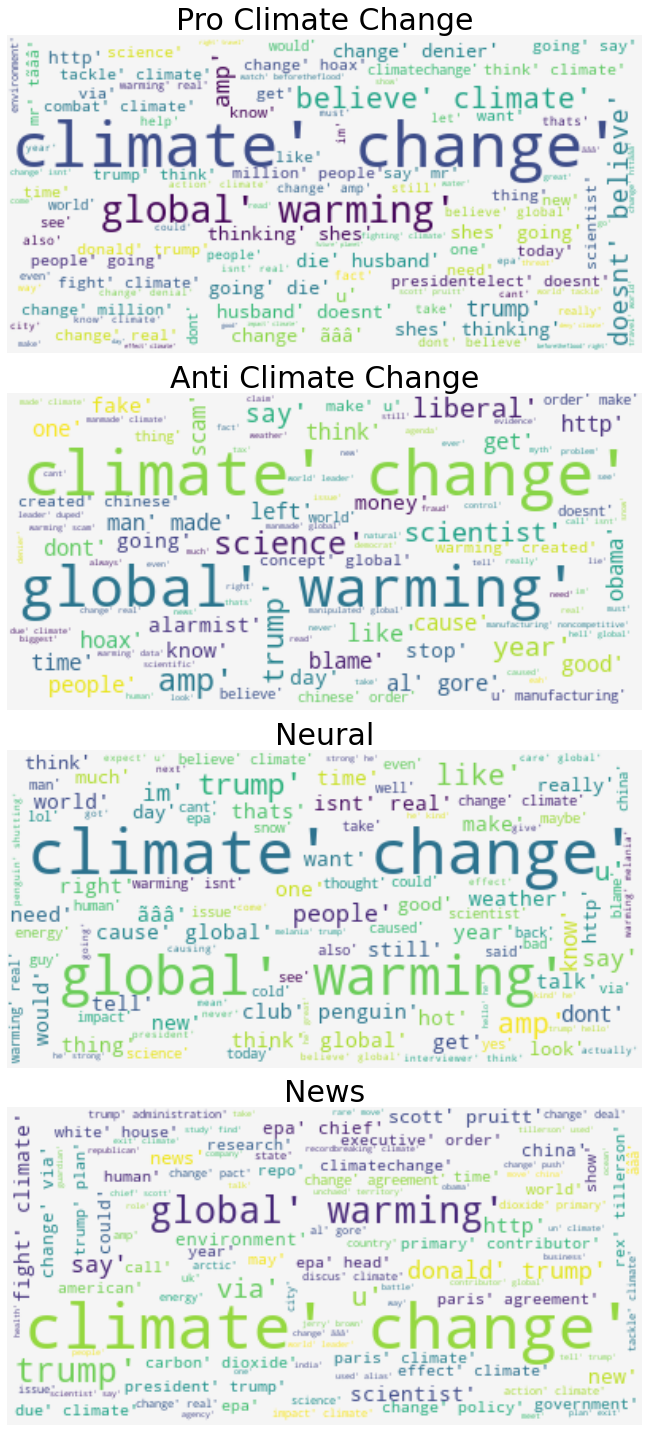

In [6]:
df_1 = clean_train_df[clean_train_df['sentiment']==1]
df_2 = clean_train_df[clean_train_df['sentiment']==-1]
df_3 = clean_train_df[clean_train_df['sentiment']==0]
df_4 = clean_train_df[clean_train_df['sentiment']==2]

tweet_1=[]
for tweet in df_1.message_lemmatized:
    tweet_1+=tweet
tweet_2 =[]
for tweet in df_2.message_lemmatized:
    tweet_2+=tweet
tweet_3 = []
for tweet in df_3.message_lemmatized:
    tweet_3+=tweet
tweet_4 = []
for tweet in df_4.message_lemmatized:
    tweet_4+=tweet

wordcloud_1 = WordCloud(max_font_size=50, max_words=100, background_color="whitesmoke").generate(str(tweet_1))
wordcloud_2 = WordCloud(max_font_size=50, max_words=100, background_color="whitesmoke").generate(str(tweet_2))
wordcloud_3 = WordCloud(max_font_size=50, max_words=100, background_color="whitesmoke").generate(str(tweet_3))
wordcloud_4 = WordCloud(max_font_size=50, max_words=100, background_color="whitesmoke").generate(str(tweet_4))

fig, ax = plt.subplots(4, 1, figsize = (20, 20), facecolor = None)
#plt.figure(figsize = (10, 10), facecolor = None)
plt.tight_layout(pad = 0)
#plt.tight_layout(pad = 0.4)

# Display the generated image:
ax[0].imshow(wordcloud_1, interpolation='bilinear')
ax[0].set_title('Pro Climate Change', fontsize=30)
ax[0].axis('off')
ax[1].imshow(wordcloud_2, interpolation='bilinear')
ax[1].set_title('Anti Climate Change', fontsize=30)
ax[1].axis('off')
ax[2].imshow(wordcloud_3, interpolation='bilinear')
ax[2].set_title('Neural', fontsize=30)
ax[2].axis('off')
ax[3].imshow(wordcloud_4, interpolation='bilinear')
ax[3].set_title('News', fontsize=30)
ax[3].axis('off')

plt.tight_layout()
plt.show()

Visualizing the frequenncy of the most commonly occuring words per class using a **Bar Chart**

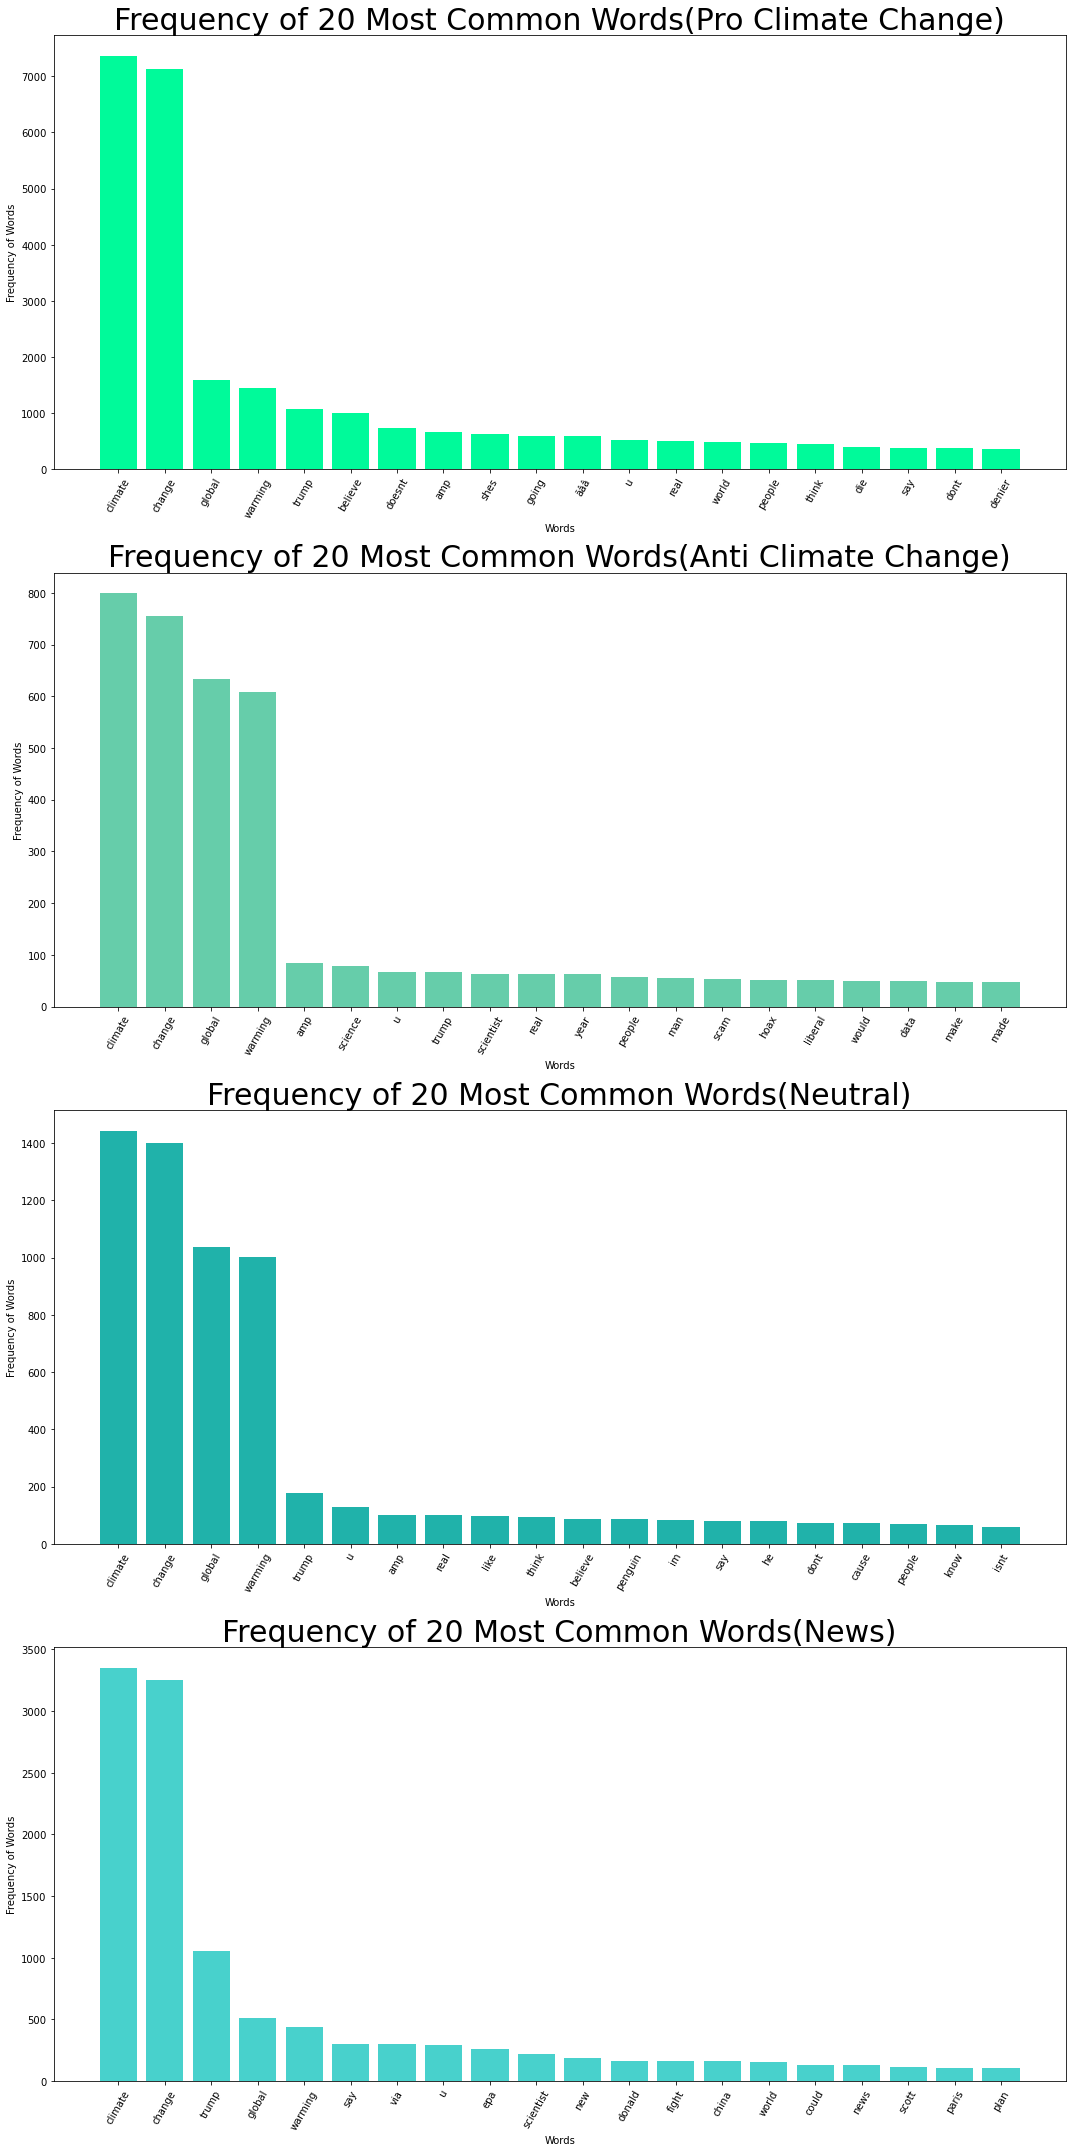

In [66]:
mostcommon1 = FreqDist(tweet_1).most_common(20)
mostcommon2 = FreqDist(tweet_2).most_common(20)
mostcommon3 = FreqDist(tweet_3).most_common(20)
mostcommon4 = FreqDist(tweet_4).most_common(20)

fig= plt.figure(figsize = (15, 30), facecolor = None)

fig.add_subplot(4,1,1).set_title('Frequency of 20 Most Common Words(Pro Climate Change)', fontsize=30)
x, y = zip(*mostcommon1)
plt.bar(x, y, color='mediumspringgreen')
plt.xlabel('Words')
plt.ylabel('Frequency of Words')
plt.xticks(rotation=60)

fig.add_subplot(4,1,2).set_title('Frequency of 20 Most Common Words(Anti Climate Change)', fontsize=30)
x, y = zip(*mostcommon2)
plt.bar(x, y, color='mediumaquamarine')
plt.xlabel('Words')
plt.ylabel('Frequency of Words')
plt.xticks(rotation=60)

fig.add_subplot(4,1,3).set_title('Frequency of 20 Most Common Words(Neutral)', fontsize=30)
x, y = zip(*mostcommon3)
plt.bar(x, y, color='lightseagreen')
plt.xlabel('Words')
plt.ylabel('Frequency of Words')
plt.xticks(rotation=60)

fig.add_subplot(4,1,4).set_title('Frequency of 20 Most Common Words(News)', fontsize=30)
x, y = zip(*mostcommon4)
plt.bar(x, y, color='mediumturquoise')
plt.xlabel('Words')
plt.ylabel('Frequency of Words')
plt.xticks(rotation=60)

plt.tight_layout()
plt.show()

The key take away from these word clouds and the bar plot is that there are phrases that are specific to each class, broken down as follows:

* News: "Donald Trump", "say", "scientists", "news"
* Neutral: "People", "think"
* Anti: "Scam", "hoax", "made"
* Pro: "Believe", "real", "denier"

However, there are still some phrases that are common to all the classes such as: **climate, change, global**, **warming** and **trump**.


<a id="four"></a>
## 4. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>



### 4.1 Text Cleaning

We nned to convert the text data into a usable format. Our first step will be to removing noise (i.e. unneccesary information) 
This involves the following steps:

* making everything lower case
* removing the web-urls
* removing punctuation

#### Convert to lowercase

In [13]:
# text cleaning...
train_df['message'] = train_df['message'].str.lower()
train_df.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesn't think carbon di...,625221
1,1,it's not like we lack evidence of anthropogeni...,126103
2,2,rt @rawstory: researchers say we have three ye...,698562
3,1,#todayinmaker# wired : 2016 was a pivotal year...,573736
4,1,"rt @soynoviodetodas: it's 2016, and a racist, ...",466954


####  Remove Tweet Handles and Web Urls

In [14]:
def handles(words):
    pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    subs_url = r'url-web'
    
    words = re.sub(pattern_url, "", words)
    words = re.sub("rt", "", words)
    words = re.sub(r'@\w+', "", words)
    
    
    #df['message'] = df['message'].replace(to_replace = pattern_url, value = subs_url, regex = True, inplace=True)
    #df['message'] = df['message'].replace(to_replace = 'rt', value = '', inplace=True)
    
    return words

#### Remove Puncuation

In [15]:
def remove_punct(words):
    text=[]
    words=words.split()
    for word in words:
        text.append(''.join([l for l in word if l.isalpha()]))
    return ' '.join(text)

train_df['message_punct']=train_df['message'].apply(handles)
train_df['message_punct']=train_df['message_punct'].apply(remove_punct)

In [16]:
train_df.head()

,sentiment,message,tweetid,message_punct
0,1,polyscimajor epa chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...
1,1,it's not like we lack evidence of anthropogeni...,126103,its not like we lack evidence of anthropogenic...
2,2,rt @rawstory: researchers say we have three ye...,698562,researchers say we have three years to act on...
3,1,#todayinmaker# wired : 2016 was a pivotal year...,573736,todayinmaker wired was a pivotal year in the...
4,1,"rt @soynoviodetodas: it's 2016, and a racist, ...",466954,its and a racist sexist climate change denyi...


#### Tokenization

We will use a tokeniser to divide our text into a sequence of tokens, or simply a sequence of words. 

In [17]:
tokeniser = TreebankWordTokenizer()
#tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
train_df['message_token'] = train_df['message_punct'].apply(tokeniser.tokenize)
train_df.head()

,sentiment,message,tweetid,message_punct,message_token
0,1,polyscimajor epa chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...,"[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,it's not like we lack evidence of anthropogeni...,126103,its not like we lack evidence of anthropogenic...,"[its, not, like, we, lack, evidence, of, anthr..."
2,2,rt @rawstory: researchers say we have three ye...,698562,researchers say we have three years to act on...,"[researchers, say, we, have, three, years, to,..."
3,1,#todayinmaker# wired : 2016 was a pivotal year...,573736,todayinmaker wired was a pivotal year in the...,"[todayinmaker, wired, was, a, pivotal, year, i..."
4,1,"rt @soynoviodetodas: it's 2016, and a racist, ...",466954,its and a racist sexist climate change denyi...,"[its, and, a, racist, sexist, climate, change,..."


#### Remove stop words

Let us remove the common English words that do not add any value to our text data.

In [18]:
def remove_stop_words(tokens):    
    return [t for t in tokens if t not in stopwords.words('english')]
train_df['message_nonstop']=train_df['message_token'].apply(remove_stop_words)
train_df.head()


,sentiment,message,tweetid,message_punct,message_token,message_nonstop
0,1,polyscimajor epa chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...,"[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,it's not like we lack evidence of anthropogeni...,126103,its not like we lack evidence of anthropogenic...,"[its, not, like, we, lack, evidence, of, anthr...","[like, lack, evidence, anthropogenic, global, ..."
2,2,rt @rawstory: researchers say we have three ye...,698562,researchers say we have three years to act on...,"[researchers, say, we, have, three, years, to,...","[researchers, say, three, years, act, climate,..."
3,1,#todayinmaker# wired : 2016 was a pivotal year...,573736,todayinmaker wired was a pivotal year in the...,"[todayinmaker, wired, was, a, pivotal, year, i...","[todayinmaker, wired, pivotal, year, war, clim..."
4,1,"rt @soynoviodetodas: it's 2016, and a racist, ...",466954,its and a racist sexist climate change denyi...,"[its, and, a, racist, sexist, climate, change,...","[racist, sexist, climate, change, denying, big..."


To convert our words into their root form, we will use the following two techniques:
* Stemming
* Lemmatization

#### Stemming

In [19]:
#function to stem our words
def return_stemmer(words):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]
train_df['message_stemmed'] = train_df['message_nonstop'].apply(return_stemmer)
train_df.head()


,sentiment,message,tweetid,message_punct,message_token,message_nonstop,message_stemmed
0,1,polyscimajor epa chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...,"[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,it's not like we lack evidence of anthropogeni...,126103,its not like we lack evidence of anthropogenic...,"[its, not, like, we, lack, evidence, of, anthr...","[like, lack, evidence, anthropogenic, global, ...","[like, lack, evid, anthropogen, global, warm]"
2,2,rt @rawstory: researchers say we have three ye...,698562,researchers say we have three years to act on...,"[researchers, say, we, have, three, years, to,...","[researchers, say, three, years, act, climate,...","[research, say, three, year, act, climat, chan..."
3,1,#todayinmaker# wired : 2016 was a pivotal year...,573736,todayinmaker wired was a pivotal year in the...,"[todayinmaker, wired, was, a, pivotal, year, i...","[todayinmaker, wired, pivotal, year, war, clim...","[todayinmak, wire, pivot, year, war, climat, c..."
4,1,"rt @soynoviodetodas: it's 2016, and a racist, ...",466954,its and a racist sexist climate change denyi...,"[its, and, a, racist, sexist, climate, change,...","[racist, sexist, climate, change, denying, big...","[racist, sexist, climat, chang, deni, bigot, l..."


#### Lemmatization

In [20]:
#function to lemmatize our words
def return_lemmer(words):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]
train_df['message_lemmatized'] = train_df['message_nonstop'].apply(return_lemmer)
train_df.head()

,sentiment,message,tweetid,message_punct,message_token,message_nonstop,message_stemmed,message_lemmatized
0,1,polyscimajor epa chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...,"[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,it's not like we lack evidence of anthropogeni...,126103,its not like we lack evidence of anthropogenic...,"[its, not, like, we, lack, evidence, of, anthr...","[like, lack, evidence, anthropogenic, global, ...","[like, lack, evid, anthropogen, global, warm]","[like, lack, evidence, anthropogenic, global, ..."
2,2,rt @rawstory: researchers say we have three ye...,698562,researchers say we have three years to act on...,"[researchers, say, we, have, three, years, to,...","[researchers, say, three, years, act, climate,...","[research, say, three, year, act, climat, chan...","[researcher, say, three, year, act, climate, c..."
3,1,#todayinmaker# wired : 2016 was a pivotal year...,573736,todayinmaker wired was a pivotal year in the...,"[todayinmaker, wired, was, a, pivotal, year, i...","[todayinmaker, wired, pivotal, year, war, clim...","[todayinmak, wire, pivot, year, war, climat, c...","[todayinmaker, wired, pivotal, year, war, clim..."
4,1,"rt @soynoviodetodas: it's 2016, and a racist, ...",466954,its and a racist sexist climate change denyi...,"[its, and, a, racist, sexist, climate, change,...","[racist, sexist, climate, change, denying, big...","[racist, sexist, climat, chang, deni, bigot, l...","[racist, sexist, climate, change, denying, big..."


In [85]:
#train_df.to_csv('clean_train.csv', index=None)
#clean_train_df=pd.read_csv('clean_train.csv')
#clean_train_df.head()

### 4.2 Feature Extraction

We now want to extract features from our text data. We will vectorize our text data so as to transform the text into numbers. This way, it can be accpeted by our model.

In [6]:
def join_w(words):
    words=' '.join(words)
    return words
    

In [7]:
#Vectorize our text data so as to transform our text into numbers. This way, it can be accpeted by our model.
vect = TfidfVectorizer(lowercase=False, stop_words='english', ngram_range=(1, 4), min_df=2, 
                             max_df=0.5)
vect_dict= vect.fit_transform(clean_train_df['message_lemmatized'].apply(join_w))

In [8]:
# create targets and features dataset
#X=vect_dict.toarray()
norm= MaxAbsScaler()
X=norm.fit_transform(vect_dict).toarray()
y=np.array(train_df['sentiment'])

In [9]:
print(type(X))

<class 'numpy.ndarray'>


### 4.3 Resampling the Data

From our EDA, we observed that our dataset was quite imbalanced. This is not favourable for our model as it may be better at classifying the Pro Climate class as compared to the rest of the classes. To avoid this, we are going to resample our data. To find a middle ground among the classes, we will resample to 4000 observations in each class (i.e. half the majority class) so that we perform both upsampling and downsampling.

In [10]:
#get the sentiment labels
sentiment_labels=list(train_df_sum.index)
print(sentiment_labels)
#train_df_sum.loc[-1]['Sum']

[-1, 0, 1, 2]


In [11]:
#combining the features and labels
data = np.concatenate([X, y[:,np.newaxis]], axis=1)


In [12]:
data.shape

(15819, 35505)

In [13]:
class_size=4000
resampled_classes = []

# For each label
for label in sentiment_labels:
    # Get num. of observations from this class
    label_size = train_df_sum.loc[label]['Sum']
    
    # If label_size < class size the upsample, else downsample
    if label_size < class_size:
        # Upsample
        label_data = data[data[:,-1] == label]
        label_resampled = resample(label_data,
                                  replace=True, # sample with replacement (we need to duplicate observations)
                                  n_samples=class_size, # number of desired samples
                                  random_state=27) # reproducible results
    else:
        # Downsample
        label_data = data[data[:,-1] == label]
        label_resampled = resample(label_data,
                                  replace=False, # sample without replacement (no need for duplicate observations)
                                  n_samples=class_size, # number of desired samples
                                  random_state=27) # reproducible results
        
    resampled_classes.append(label_resampled)

In [14]:
#combine all the resampled classes
resampled_data = np.concatenate(resampled_classes, axis=0)
resampled_data.shape

(16000, 35505)

This is expected. This is because we have 4 classes, each resampled to 40000 observations gives us 16000 total observations.

In [15]:
#Seperate the features
X_resampled = resampled_data[:,:-1]

In [16]:
#Seperate the labels
y_resampled = resampled_data[:,-1]

In [17]:
#Number of samples per class after resampling
heights = [len(y_resampled[y_resampled == label]) for label in sentiment_labels]
print(heights)

[4000, 4000, 4000, 4000]


In [18]:
train_df_sum_resampled = pd.DataFrame(zip(heights, sentiment_labels), columns=['Sum','Sentiment'])
train_df_sum_resampled = train_df_sum_resampled.sort_values(by='Sum',ascending=True)
train_df_sum_resampled

,Sum,Sentiment
0,4000,-1
1,4000,0
2,4000,1
3,4000,2


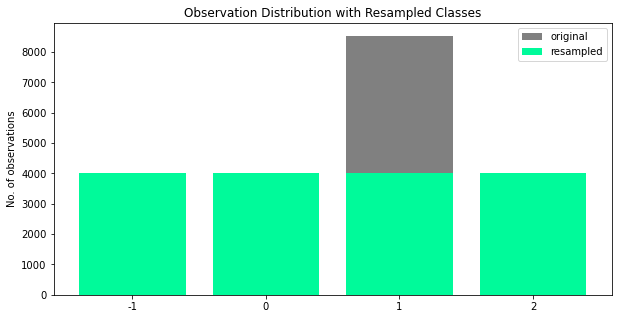

In [20]:
#plot bar chart showing the distribution of observations after resampling

plt.bar(range(len(train_df_sum)),train_df_sum['Sum'],color='grey')
#plt.bar(range(len(train_df_sum_resampled)),train_df_sum_resampled['Sum'],color='mediumspringgreen')
plt.bar(range(len(train_df_sum)),[4000,4000,4000,4000],color='mediumspringgreen')
plt.xticks(range(len(train_df_sum)),train_df_sum.index)
plt.ylabel("No. of observations")
plt.legend(['original','resampled'])
plt.title('Observation Distribution with Resampled Classes')
plt.show()

<a id="five"></a>
## 5. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


Let us fit our training data on various models and see how they perform.

In [24]:
# create targets and features dataset
X=vect_dict
y=train_df['sentiment']

In [25]:
# split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

### 5.1 Logistic Regression Model

The Logistic Regression Model fits the data into an S-shaped sigmoid curve with each data point along the curve representing the probability of an observation belonging to the positive class in our dataset. And depending on the probability threshold defined, it will be classified in either of the classes.

From this explanation, we can see that logistic regression is a binary classification model. However, it can still accommodate multiple classes,like in our case-4, through a One vs Rest scheme (i.e. one class vs the rest of the classes). 
This involves splitting the multi-class classification problem into multiple binary classification problems.

In [21]:
lr = LogisticRegression(multi_class='ovr')

In [26]:
lr = LogisticRegression(multi_class='ovr')
lr.fit(X_train, y_train)

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='ovr')

#### Fit Model to Resampled Data

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [22]:
lr.fit(X_train, y_train)

LogisticRegression(multi_class='ovr')

### 5.2 Support Vector Classifier

SVM works by plottting the labelled training data as points in space and will look for the widest, clearest gap between points belonging to group A and points belonging to group B. The basic idea is to separate points using a  (𝑝−1)  dimensional hyperplane. This means that the SVM will construct a decision boundary such that points on the left are assigned a label of  𝐴  and points on the right are assigned a label of  𝐵 . When finding this separating hyperplane we wish to maximise the distance of the nearest points to the hyperplane. The data points which dictate where the separating hyperplane goes are called support vectors.

In [35]:
svc = SVC(kernel='rbf', C=1, gamma=0.1)
svc_fit=svc.fit(X_train, y_train)

### 5.3 Multinomial Naive Bayes Model

Naive Bayes is a classification algorithm that uses the principle of Bayes theorem to make classifications. It makes an explicit assumption that the features are independent given the class label. The benefits of Naive Bayes are that the model is simple to build and is useful on large data sets. Here, we apply the Multinomial Naive Bayes which is used for discrete counts since we are working with count of words occurring in a document.

In [28]:
nb = MultinomialNB() 
nb_fit=nb.fit(X_train, y_train)

### 5.4 Random Forest Classifier

A decision tree is a tree-like decision support tool that uses a model of decisions and their possible consequences. 
Such a tree is built through a process known as binary recursive partitioning. This is an iterative process of splitting the data into partitions, and then splitting it up further on each of the branches. This is until it reaches the terminal nodes which predict the outcome/represent class labels.

In [32]:
forest = RandomForestClassifier(n_estimators=100, random_state=27)
forest_fit=forest.fit(X_train, y_train)

<a id="six"></a>
## 6. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


To gauge how our models performed, we generate a **classification report** for each. This is a text report showing the main classification metrics:

##### Accuracy :
Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations 

Using the formula:  $$ Accuracy = \frac{Correct \space predictions}{Total \space predictions} = \frac{TP \space + TN}{TP \space + TN \space + FP \space + FP} $$


##### Precision :
Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.

Using the formula: $$ Precision = \frac{TP}{TP \space + FP} = \frac{TP}{Total \space Predicted \space Positive} $$


##### Recall (Sensitivity) :
Recall is the ratio of correctly predicted positive observations to the all observations in actual class. 

Using the formula: $$ Recall = \frac{TP}{TP \space + FN} = \frac{TP}{Total \space Actual \space Positive}$$

##### F1 score :
F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution.

Using the formula: $$F_1 = 2 \times \frac {Precision \space \times \space Recall }{Precision \space + \space Recall }$$



### 6.1.1 Logistic Regression(Unbalanced)

In [27]:
# Generate predictions on the test set
y_pred = lr.predict(X_test)

In [28]:
# Generate classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.69      0.40      0.51       246
           0       0.52      0.42      0.47       455
           1       0.75      0.85      0.80      1730
           2       0.74      0.70      0.72       733

    accuracy                           0.72      3164
   macro avg       0.67      0.59      0.62      3164
weighted avg       0.71      0.72      0.71      3164



#### 6.1.2 Logistic Regression (Balanced)

In [23]:
# Generate predictions on the test set
y_pred1 = lr.predict(X_test)

In [24]:
# Generate classification report
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

        -1.0       0.89      0.95      0.92       767
         0.0       0.80      0.85      0.83       837
         1.0       0.83      0.66      0.73       859
         2.0       0.80      0.88      0.84       737

    accuracy                           0.83      3200
   macro avg       0.83      0.83      0.83      3200
weighted avg       0.83      0.83      0.82      3200



There is a significant increase in the performance of our Logistic Regression model after balancing our data. This attributed to the fact that Logistic Regression models work well with balanced data. We shall use the balanced data set on the rest of our models.

### 6.2 Support Vector Classifier

In [36]:
# Generate predictions on the test set
svc_pred = svc_fit.predict(X_test)

In [37]:
# Generate classification report
print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

        -1.0       0.93      0.92      0.92       767
         0.0       0.79      0.85      0.82       837
         1.0       0.79      0.71      0.75       859
         2.0       0.80      0.85      0.82       737

    accuracy                           0.83      3200
   macro avg       0.83      0.83      0.83      3200
weighted avg       0.83      0.83      0.83      3200



### 6.3 Naive Bayes Model

In [29]:
# Generate predictions on the test set
nb_pred = nb_fit.predict(X_test)

In [30]:
# Generate classification report
print(classification_report(y_test, nb_pred))

              precision    recall  f1-score   support

        -1.0       0.77      0.93      0.84       767
         0.0       0.70      0.80      0.75       837
         1.0       0.81      0.53      0.64       859
         2.0       0.79      0.81      0.80       737

    accuracy                           0.76      3200
   macro avg       0.77      0.77      0.76      3200
weighted avg       0.77      0.76      0.75      3200



### 6.4 Random Forest Classifier

In [33]:
# Generate predictions on the test set
forest_pred = forest_fit.predict(X_test)

In [34]:
# Generate classification report
print(classification_report(y_test, forest_pred))

              precision    recall  f1-score   support

        -1.0       0.95      0.95      0.95       767
         0.0       0.76      0.91      0.83       837
         1.0       0.84      0.61      0.70       859
         2.0       0.79      0.88      0.83       737

    accuracy                           0.83      3200
   macro avg       0.83      0.83      0.83      3200
weighted avg       0.83      0.83      0.82      3200



### 6.4 Compare Model Performance

For better comparison, let as compute the weighted F1 metric for each of our models and plot them.

In [62]:
#preds=[y_pred1, svc_pred, nb_pred, forest_pred]

def f1_metric(y_test,pred):
    #function to compute F1 score metric for each model
    f1=metrics.f1_score(y_test, pred, average='weighted')
    return f1
f1_scores=[f1_metric(y_test,y_pred1), f1_metric(y_test,svc_pred), f1_metric(y_test,nb_pred), f1_metric(y_test,forest_pred)]
print(f1_scores)

[0.8246426862873127, 0.8256585691614375, 0.7538820793876593, 0.8239787024197647]


In [59]:
#dataframe to store model and corresponding F1 score
models_list=['Logistic Regression', 'SVC', 'MultinomialNB', 'Random Forest']
bars=pd.DataFrame(zip(models_list, f1_scores), columns=['Model','F1 Score'])
bars = bars.sort_values(by='F1 Score', ascending=False)
bars

,Model,F1 Score
1,SVC,0.825659
0,Logistic Regression,0.824643
3,Random Forest,0.823979
2,MultinomialNB,0.753882


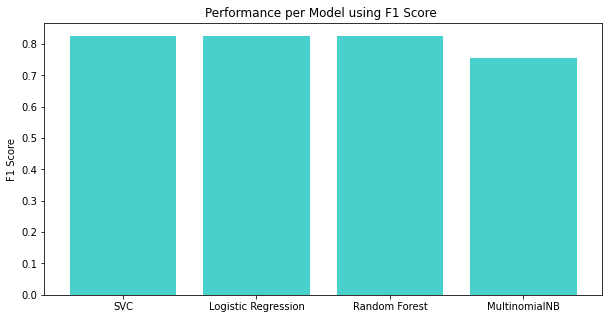

In [60]:
#plot F1 scores
plt.bar(range(len(f1_scores)),bars['F1 Score'],color='mediumturquoise')
plt.xticks(range(len(f1_scores)),bars['Model'])
plt.ylabel("F1 Score")
plt.title('Performance per Model using F1 Score ')
plt.show()

The SVC, Logistic Regression and Random Forest Models performed relatively the same. They also did fairly well as compared to the MultinomialNB.

### 7. Kaggle Submission

In [56]:
#create dataframe with tweed id from test data
submission = test_df[['tweetid']]
submission

,tweetid
0,169760
1,35326
2,224985
3,476263
4,872928
...,...
10541,895714
10542,875167
10543,78329
10544,867455


In [57]:
#pre processing pipeline (same as for the train data)
def process_test(test_df):
    test_df['message'] = test_df['message'].str.lower()
    test_df['message_punct']=test_df['message'].apply(handles)
    test_df['message_punct']=test_df['message_punct'].apply(remove_punct)
    test_df['message_token'] = test_df['message_punct'].apply(tokeniser.tokenize)
    test_df['message_nonstop']=test_df['message_token'].apply(remove_stop_words)
    test_df['message_lemmatized'] = test_df['message_nonstop'].apply(return_lemmer)
    test_data= vect.transform(test_df['message_lemmatized'].apply(join_w))
    
    return test_data

test_data=process_test(test_df)

In [58]:
#making predictions on the test data
predictions=lr.predict(test_data)

In [59]:
#add the submissions column to the dataframe
submission['sentiment']=predictions
submission

C:\Users\DELL\AppData\Local\Temp/ipykernel_8068/2464283266.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['sentiment']=predictions


,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,0
4,872928,0
...,...,...
10541,895714,-1
10542,875167,1
10543,78329,2
10544,867455,0


In [60]:
#create submission file
submission.to_csv('submission.csv', index=None)

In [61]:
#load the file for confirmation
subdf=pd.read_csv('submission.csv')
subdf.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,0
4,872928,0
